In [1]:
import sys
sys.path.insert(0, '..')

import PipelineTS
PipelineTS.__version__

'0.3.10'

# Using Optuna

In [2]:
import pandas as pd

# define optimization target
from sklearn.metrics import mean_absolute_error
evaluation_metric = mean_absolute_error

# preprocess data
from PipelineTS.dataset import LoadMessagesSentDataSets
init_data = LoadMessagesSentDataSets()
time_col = init_data.time_col
target_col = init_data.target_col

init_data[time_col] = pd.to_datetime(init_data[time_col])

# dividing the training set and the validation set
valid_data = init_data[[time_col, target_col]].iloc[-30:, :]
data = init_data[[time_col, target_col]].iloc[:-30, :]

# set the computing device, which will specify the computing device for the neural network model
# default to 'auto'
accelerator = 'auto'  

# set the step size for prediction
n = 30

from PipelineTS.pipeline import ModelPipeline

In [3]:
import optuna
from PipelineTS.nn_model import StackingRNNModel

# The objective function is referenced from https://optuna.org/#code_ScikitLearn
# 1. Define an objective function to be maximized.
def objective(trial):

    # 2. Suggest values for the hyperparameters using a trial object.
    lags = trial.suggest_int('lags', 8, 60, step=2)
    blocks = trial.suggest_int('blocks', 1, 6, log=True)
    dropout = trial.suggest_float('dropout', 0.1, 0.5, log=True)

    pipeline = ModelPipeline(
        time_col=time_col,
        target_col=target_col,
        lags=lags,  
        random_state=42,
        include_models=StackingRNNModel,
        # Specify the performance evaluation criteria when training the model with the pipeline. The default is mean absolute error.
        metric=evaluation_metric,
        # Is it better to have a lower performance evaluation standard
        metric_less_is_better=True,
        # set the computing device, which will specify the computing device for the neural network model
        accelerator=accelerator,
        
        # False for MinMaxScaler, True for QuantileTransformer, None means no data be scaled
        scaler=False,

        # Here's an example where you can specify model hyperparameters like this
        StackingRNNModel__blocks=blocks,
        StackingRNNModel__dropout=dropout
    )

    pipeline.fit(data, valid_data=valid_data)

    return evaluation_metric(pipeline.predict(n)[target_col].values, valid_data[target_col].values)

# 3. Create a study object and optimize the objective function.
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20)

[I 2023-11-24 15:46:44,383] A new study created in memory with name: no-name-fa93226a-b9ab-4165-8d9e-c052a9f0183e
MPS  available: True   | MPS  use: True
CUDA available: False  | CUDA use: False
TPU  available: False  | TPU  use: False
CPU  available: True   | CPU  use: False

15:46:44 2023-11-24 - PipelineTS - There are a total of 1 models to be trained.
15:46:44 2023-11-24 - PipelineTS - [model 0] fitting and evaluating StackingRNNModel...
[I 2023-11-24 15:47:07,232] Trial 0 finished with value: 12663.345419663687 and parameters: {'lags': 58, 'blocks': 4, 'dropout': 0.1244809496432892}. Best is trial 0 with value: 12663.345419663687.
MPS  available: True   | MPS  use: True
CUDA available: False  | CUDA use: False
TPU  available: False  | TPU  use: False
CPU  available: True   | CPU  use: False

15:47:07 2023-11-24 - PipelineTS - There are a total of 1 models to be trained.
15:47:07 2023-11-24 - PipelineTS - [model 0] fitting and evaluating StackingRNNModel...
[I 2023-11-24 15:47:35,3

In [6]:
study.best_trial.params

{'lags': 8, 'blocks': 2, 'dropout': 0.4923779061010002}

MPS  available: True   | MPS  use: True
CUDA available: False  | CUDA use: False
TPU  available: False  | TPU  use: False
CPU  available: True   | CPU  use: False

16:07:32 2023-11-24 - PipelineTS - There are a total of 1 models to be trained.
16:07:32 2023-11-24 - PipelineTS - [model 0] fitting and evaluating StackingRNNModel...


mae: 8892.59814931117


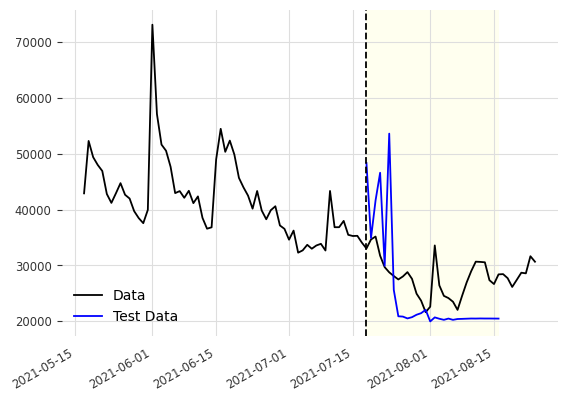

In [3]:
from PipelineTS.nn_model import StackingRNNModel

pipeline = ModelPipeline(
    time_col=time_col,
    target_col=target_col,
    lags=8,  
    random_state=42,
    include_models=StackingRNNModel,
    # Specify the performance evaluation criteria when training the model with the pipeline. The default is mean absolute error.
    metric=evaluation_metric,
    # Is it better to have a lower performance evaluation standard
    metric_less_is_better=True,
    # set the computing device, which will specify the computing device for the neural network model
    accelerator=accelerator,
    
    # False for MinMaxScaler, True for QuantileTransformer, None means no data be scaled
    scaler=False,

    StackingRNNModel__blocks=2,
    StackingRNNModel__dropout=0.4923779061010002
)

pipeline.fit(data)


prediction = pipeline.predict(n)

print('mae:', evaluation_metric(prediction[target_col].values, valid_data[target_col].values))

from PipelineTS.plot import plot_data_period

plot_data_period(init_data.iloc[-100:, :], prediction, 
                 time_col=time_col, target_col=target_col)

In [5]:
data

,date,tc
0,2020-01-01,51446
1,2020-01-02,54437
2,2020-01-03,54318
3,2020-01-04,62115
4,2020-01-05,64416
...,...,...
567,2021-07-21,31739
568,2021-07-22,29697
569,2021-07-23,28765
570,2021-07-24,28105


In [4]:
prediction

,date,tc
0,2021-07-18,48305.326813
1,2021-07-19,34894.496384
2,2021-07-20,41629.011723
3,2021-07-21,46572.390368
4,2021-07-22,29946.033983
5,2021-07-23,53565.695479
6,2021-07-24,25627.490812
7,2021-07-25,20906.678730
8,2021-07-26,20852.280277
9,2021-07-27,20524.278511
